# Used Packages

In [1]:
import os
import glob
import gc

import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

from scipy.spatial.transform import Rotation as R

from utils.MovingAverager import *
from collections import defaultdict
from torchinfo import summary

from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score

# Global Variable

In [2]:
rotation = False
num_of_axie = 3

datapoint_per_second = 20
duration = 2
seq_len = 20

In [3]:
validation_traj = np.load(f'/root/Calibration/R403/npys/all_user_match_data.npy', allow_pickle=True)

In [4]:
parent_path = '/root/Calibration/R403/model'
tim = datetime.now().strftime("%b%d%Y")
path = os.path.join(parent_path, tim+'_Calibrate')
try:
    os.makedirs(path, exist_ok=True)
    print("Directory '%s' created successfully" % path)
except OSError as error:
    print("Directory '%s' can not be created")

Directory '/root/Calibration/R403/model/Jun082024_Calibrate' created successfully


In [5]:
class KalmanFilter:
    def __init__(self, dt, gyro_noise_std, acc_noise_std):
        self.dt = dt
        self.gyro_noise_std = gyro_noise_std
        self.acc_noise_std = acc_noise_std
        
        self.Q = np.eye(3) * gyro_noise_std**2
        self.R = np.eye(3) * acc_noise_std**2
        
        self.P = np.eye(3)
        self.x = np.zeros(3)
    
    def predict(self, gyro_measurements):
        F = np.eye(3) + self.dt * self.skew_symmetric(gyro_measurements)
        self.x = F @ self.x
        self.P = F @ self.P @ F.T + self.Q
    
    def update(self, acc_measurements, Rk):
        z = acc_measurements
        H = np.eye(3)
        y = z - H @ self.x
        S = H @ self.P @ H.T + Rk
        K = self.P @ H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = (np.eye(3) - K @ H) @ self.P
    
    def skew_symmetric(self, v):
        return np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])

class AttitudeEstimator:
    def __init__(self, dt, gyro_noise_std, acc_noise_std, method='STF'):
        self.kf = KalmanFilter(dt, gyro_noise_std, acc_noise_std)
        self.method = method
    
    def estimate_attitude(self, gyro_measurements, acc_measurements):
        self.kf.predict(gyro_measurements)
        Rk = self.adaptive_measurement_noise_covariance(acc_measurements)
        self.kf.update(acc_measurements, Rk)
        return self.kf.x
    
    def adaptive_measurement_noise_covariance(self, acc_measurements):
        if self.method == 'STF':
            return self.adaptive_measurement_noise_covariance_stf(acc_measurements)
        elif self.method == 'MTF':
            return self.adaptive_measurement_noise_covariance_mtf(acc_measurements)
        else:
            raise ValueError("Method must be 'STF' or 'MTF'")
    
    def adaptive_measurement_noise_covariance_stf(self, acc_measurements):
        innovation = acc_measurements - self.kf.x
        St = np.sum(innovation**2) / 3 - np.trace(self.kf.R) / 3
        St = max(0, St)
        return np.eye(3) * St
    
    def adaptive_measurement_noise_covariance_mtf(self, acc_measurements):
        innovation = acc_measurements - self.kf.x
        St = np.zeros(3)
        for i in range(3):
            St[i] = max(0, innovation[i]**2 - self.kf.R[i, i])
        return np.diag(St)
    
    def get_roll_pitch(self):
        roll = np.arctan2(self.kf.x[1], self.kf.x[2])
        pitch = np.arctan2(-self.kf.x[0], np.sqrt(self.kf.x[1]**2 + self.kf.x[2]**2))
        return roll, pitch

class RotationMatrixCalculator:
    @staticmethod
    def from_roll_pitch(roll, pitch):
        R_x = np.array([
            [1, 0, 0],
            [0, np.cos(roll), -np.sin(roll)],
            [0, np.sin(roll), np.cos(roll)]
        ])
        
        R_y = np.array([
            [np.cos(pitch), 0, np.sin(pitch)],
            [0, 1, 0],
            [-np.sin(pitch), 0, np.cos(pitch)]
        ])
        
        R = R_x @ R_y
        return R

estimator = AttitudeEstimator(0.05, 0.01, 0.1, 'MTF')    

def process_sequence(gyro_data, acc_data, acc_lin_data, mag_data):
    rotation_matrices = []
    rotated_acc_data = []
    rotated_acc_lin_data = []
    rotated_mag_data = []
    rotated_gyro_data = []
    
    for gyro_measurements, acc_measurements, acc_lin_measurements, mag_measurements in zip(gyro_data, acc_data, acc_lin_data, mag_data):
        estimator.estimate_attitude(np.array(gyro_measurements), np.array(acc_measurements))
        roll, pitch = estimator.get_roll_pitch()
        R = RotationMatrixCalculator.from_roll_pitch(roll, pitch)
        
        rotated_acc = R @ np.array(acc_measurements)
        rotated_gyro = R @ np.array(gyro_measurements)
        rotated_acc_lin = R @ np.array(acc_lin_measurements)
        rotated_mag = R @ np.array(mag_measurements)
        
        rotation_matrices.append(R)
        rotated_acc_data.append(rotated_acc)
        rotated_acc_lin_data.append(rotated_acc_lin)
        rotated_gyro_data.append(rotated_gyro)
        rotated_mag_data.append(rotated_mag)
    
    return np.concatenate((np.array(rotated_acc_data), np.array(rotated_acc_lin_data), np.array(rotated_gyro_data)), axis=-1), np.array(rotated_mag_data),

In [24]:
def get_data(validation_traj, num_of_axis, rotation):
    posture_data = defaultdict(list)

    valid_data = validation_traj.item()
    for user_name in valid_data.keys():
        if user_name != 'user1':
            continue

        for path_name in valid_data[user_name].keys():
            for posture_name in valid_data[user_name][path_name].keys():
                data = valid_data[user_name][path_name][posture_name]

                if posture_name == 'ref_mag':
                    if num_of_axie == 2:
                        posture_data[posture_name].append(data[:, [0, 1, 6, 7, 5]])
                    else:
                        posture_data[posture_name].append(data[:, [0, 1, 2, 3, 4, 6, 7, 5]])
                    continue

                pos = (data[:, [0, 1]] + np.array((1, 1))) * 0.6
                imu = data[:, [3, 4, 5, 6, 7, 8, 9, 10, 11]]
                imu[:, 6:9] = imu[:, 6:9] * 180 / np.pi
                mag = data[:, [12, 13, 14]]

                if rotation:
                    imu, mag = process_sequence(imu[:, 6:9], imu[:, 0:3], imu[:, 3:6], mag)
                if num_of_axis == 2:
                    mag = np.column_stack((np.sqrt(np.sum(mag[:, :2]**2, axis=1)), mag[:, 2]))
                # imu = imu[:, [0, 3, 6, 1, 4, 7, 2, 5, 8]]
                pos_mag = np.concatenate((pos, imu, mag, data[:, [15]]), axis=-1)
                posture_data[posture_name].append(pos_mag)
    
    return posture_data

In [7]:
def split_traj(trajs, length=20):
    sp_train_traj = []
    sp_valid_traj = []
    for traj in trajs:
        for i in range(len(traj) - 2 * length + 1 - 5):
            sp_train_traj.append(traj[i:i+length])

        if len(traj) >= 2 * length:
            for i in range(len(traj) - length - 5, len(traj) - length + 1):
                sp_valid_traj.append(traj[i:i+length])
    return np.array(sp_train_traj), np.array(sp_valid_traj)

In [8]:
datapoint_per_second = 20
duration = 2
seq_len = 20

# Data Loader

In [9]:
class PairDataset(Dataset):
    def __init__(self, source_data, source_label, target_data, target_label):
        assert (source_data.shape[0] == source_label.shape[0] == target_data.shape[0] == target_label.shape[0]), f'{source_data.shape}, {source_label.shape}, {target_data.shape}, {target_label.shape}'
        self.source_data = source_data
        self.source_label = source_label
        self.target_data = target_data
        self.target_label = target_label

    def __len__(self):
        return len(self.source_data)

    def __getitem__(self, idx):
        return self.source_data[idx], self.source_label[idx], self.target_data[idx], self.target_label[idx]

In [10]:
def for_dataloaders(train_traj, valid_traj, gt='target'):
    t_data = 0
    t_label = 0
    t_target_data = 0
    v_data = 0
    v_label = 0
    v_target_data = 0
    label = 1
    label_dict = {}
    key_to_label = {}
    flag = False

    for key, value in train_traj.items():
        if key != gt:
            t_data = np.concatenate((t_data, value)) if flag else value
            t_label = np.concatenate((t_label, np.full((value.shape[0], ), label))) if flag else np.full((value.shape[0], ), label)
            flag = True
            label_dict[label] = key
            key_to_label[key] = label
            label += 1
        else:
            l = len(train_traj.values()) - 1
            t_target_data = np.tile(value, (l, 1, 1))
            label_dict[0] = key

    flag = False
    for key, value in valid_traj.items():
        if key != gt:
            label = key_to_label[key]
            v_data = np.concatenate((v_data, value)) if flag else value
            v_label = np.concatenate((v_label, np.full((value.shape[0], ), label))) if flag else np.full((value.shape[0], ), label)
            flag = True
        else:
            l = len(valid_traj.values()) - 1
            v_target_data = np.tile(value, (l, 1, 1))
            label_dict[0] = key

    train_dataset = PairDataset(
                        source_data = torch.tensor(t_data, dtype=torch.float),
                        source_label = t_label,
                        target_data = torch.tensor(t_target_data, dtype=torch.float),
                        target_label = np.zeros((len(t_target_data), ))
                    )
    
    valid_dataset = PairDataset(
                        source_data = torch.tensor(v_data, dtype=torch.float),
                        source_label = v_label,
                        target_data = torch.tensor(v_target_data, dtype=torch.float),
                        target_label = np.zeros((len(v_target_data), ))
                    )

    print(label_dict)
    return label_dict, train_dataset, valid_dataset

# Model Declaration

In [12]:
class FirstDerivativeLoss(nn.Module):
    def __init__(self, weight=None, size_average=None, reduce=None, reduction='mean'):
        super(FirstDerivativeLoss, self).__init__()

    def forward(self, source, target):
        # calculate the first derivative
        source_o = torch.reshape(source, (len(source), -1))
        target_o = torch.reshape(target, (len(target), -1))
        d_source = source_o[1:] - source_o[:-1]
        d_target = target_o[1:] - target_o[:-1]

        # calculate the loss as the mean squared error of the derivative
        loss = mae_loss(d_source, d_target)

        return loss

In [13]:
def generator_loss(z_imu, target_imu, predict_mag, target_mag, source_total_mag, target_total_mag, epoch_ratio=None):
    imu_loss = mae_loss(z_imu, target_imu)
    mag_loss = torch.sqrt(mse_loss(predict_mag, target_mag))
    d1_loss = div_loss(predict_mag, target_mag)
    
    pred_total_mag = torch.sqrt(torch.sum(torch.pow(predict_mag, 2), dim=-1))
    
    smag_limitation_loss = mae_loss(pred_total_mag, source_total_mag)
    tmag_limitation_loss = mae_loss(pred_total_mag, target_total_mag)
    
    if epoch_ratio == None:
        total_loss = imu_loss + mag_loss + d1_loss + smag_limitation_loss * 0.25 + tmag_limitation_loss * 0.75
    else:
        total_loss = (imu_loss + mag_loss * (1 + epoch_ratio) + d1_loss * (2 - epoch_ratio)) / 4 + smag_limitation_loss * 0.25 + tmag_limitation_loss * 0.75
    return total_loss, (imu_loss, mag_loss, d1_loss, smag_limitation_loss, tmag_limitation_loss)

In [14]:
num_of_classes = 1
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
ce_loss = torch.nn.CrossEntropyLoss()
mse_loss = torch.nn.MSELoss()
mae_loss = torch.nn.L1Loss()
bce_loss = torch.nn.BCELoss()
div_loss = FirstDerivativeLoss()

In [15]:
def get_tgt_mask(size) -> torch.tensor:
    # Generates a squeare matrix where the each row allows one word more to be seen
    mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
    mask = mask.float()
    mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
    mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0

    return mask.to(device)

In [16]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :].to(x.device)
        return self.dropout(x)
    

class NotSimpleTransformer(nn.Module):
    def __init__(self, seq_len=21, num_of_classes=2):
        super(NotSimpleTransformer, self).__init__()
        
        self.seq_len = seq_len
        self.num_of_classes = num_of_classes
        self.mag_axis = num_of_axie
        
        self.imu_layer = nn.Sequential(
            nn.Linear(6, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 64),
            nn.LeakyReLU(),
        )
        self.mag_layer = nn.Sequential(
            nn.Linear(self.mag_axis, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 64),
            nn.LeakyReLU(),
        )
        self.pos_encoder = PositionalEncoding(64, 0.1)
        
        self.encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=64, nhead=8, dropout=0.1, batch_first=True), num_layers=2)
        self.mag_encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=64, nhead=8, dropout=0.1, batch_first=True), num_layers=2)
        self.nn = nn.Sequential(
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 6),
        )
        
        self.decoder  = nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model=64, nhead=8, dropout=0.1, batch_first=True), num_layers=2)
#         self.decoder1 = nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model=64, nhead=8, dropout=0.1, batch_first=True), num_layers=2)
        
        self.mag_last = nn.Sequential(
            nn.Linear(64, 16),
            nn.LeakyReLU(),
            nn.Linear(16, self.mag_axis),
        )
        
    def forward(self, source_imu, target_imu, source_mag):
        length = source_imu.shape[1]
        
        ### step 1
        h_imu = self.imu_layer(source_imu)
        h_imu = self.pos_encoder(h_imu)
        
        h_t_imu = self.imu_layer(target_imu)
        h_t_imu = self.pos_encoder(h_t_imu)
        
        h_mag = self.mag_layer(source_mag)
        h_mag = self.pos_encoder(h_mag)
        h_mag = self.mag_encoder(h_mag)
        
        ### step 2
        z = self.encoder(h_imu)
        z_imu = self.nn(z)
        
        ### step 3
        
        pred_latent = self.decoder(z, h_mag, tgt_mask=get_tgt_mask(length))
        pred_mag = self.mag_last(pred_latent)
        
        return z_imu, pred_mag

In [17]:
def plot_result(result):
    pred_mag = result[0].reshape(-1, num_of_axie)
    targ_mag = result[1].reshape(-1, num_of_axie)
    x = np.arange(len(pred_mag))
    
    loss = torch.sqrt(mse_loss(torch.tensor(pred_mag), torch.tensor(targ_mag))).item()
    
    fig = plt.figure(figsize=(15, 5))
    
    for pm, tm, caxis, color in zip(pred_mag.T, targ_mag.T, ['x', 'y', 'z'][:num_of_axie], ['tab:blue', 'tab:orange', 'tab:green'][:num_of_axie]):
        plt.plot(x, pm, label=f'pred_{caxis}', color=color, linewidth=2.5, zorder=2)
        plt.plot(x, tm, '--', label=f'targ_{caxis}', color=color, linewidth=1, alpha=0.8, zorder=1)
    
    pred_total_mag = np.sqrt(np.sum(np.power(pred_mag, 2), axis=-1))
    targ_total_mag = np.sqrt(np.sum(np.power(targ_mag, 2), axis=-1))
    plt.plot(x, pred_total_mag, label=f'pred_t', color='tab:red', linewidth=2.5, zorder=2)
    plt.plot(x, targ_total_mag, '--', label=f'targ_t', color='tab:red', linewidth=1, alpha=0.8, zorder=1)
    
    plt.suptitle(f'Loss: {loss:.2f}')
    plt.legend()
    plt.show()

In [18]:
def train(dataloader, draw=False, epoch_ratio=1):
    model.train()

    g_losses = []
    imu_losses = []
    mag_losses = []
    d1_losses = []
    lim_loss = []

    for source_data, source_label, target_data, target_label in dataloader:
        optimizer.zero_grad()

        source_data = source_data.to(device)
        source_imu = source_data[:, :, 5:11] + torch.randn_like(source_data[:, :, 5:11]) * 0.75
        source_mag = source_data[:, :, 11:(11 + num_of_axie)] + torch.randn_like(source_data[:, :, 11:(11 + num_of_axie)]) * 1.5
        source_total_mag = source_data[:, :, -1]
        
        target_data = target_data.to(device)
        target_imu = target_data[:, :, 5:11]
        target_mag = target_data[:, :, 11:(11 + num_of_axie)]
        target_total_mag = target_data[:, :, -1]

        # generate mag
        z_imu, predict_mag = model(source_imu, target_imu, source_mag)
        
        # generator loss
        gen_loss, (imu_loss, mag_loss, d1_loss, smag_limitation_loss, tmag_limitation_loss) = generator_loss(z_imu, target_imu, predict_mag, target_mag,
                                                                                              source_total_mag, target_total_mag, epoch_ratio)
        
        # backward
        gen_loss.backward()
        optimizer.step()
        
        # record loss
        g_losses.append(gen_loss.item())
        imu_losses.append(imu_loss.item())
        mag_losses.append(mag_loss.item())
        d1_losses.append(d1_loss.item())
        lim_loss.append([smag_limitation_loss.item(), tmag_limitation_loss.item()])
    
    if draw:
        rs = [predict_mag[0].detach().cpu().numpy(), target_mag[0].cpu().numpy()]
        plot_result(rs)
    
    return np.mean(g_losses), np.mean(imu_losses), np.mean(mag_losses), np.mean(d1_losses), np.mean(lim_loss, axis=0)

In [19]:
def evalute(dataloader, draw=False):
    model.eval()

    g_losses = []
    imu_losses = []
    mag_losses = []
    d1_losses = []
    lim_loss = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data.to(device)
            source_imu = source_data[:, :, 5:11]
            source_mag = source_data[:, :, 11:(11 + num_of_axie)]
            source_total_mag = source_data[:, :, -1]

            target_data = target_data.to(device)
            target_imu = target_data[:, :, 5:11]
            target_mag = target_data[:, :, 11:(11 + num_of_axie)]
            target_total_mag = target_data[:, :, -1]

            # generate mag
            z_imu, predict_mag = model(source_imu, target_imu, source_mag)

            # generator loss
            gen_loss, (imu_loss, mag_loss, d1_loss, smag_limitation_loss, tmag_limitation_loss) = generator_loss(z_imu, target_imu, predict_mag, target_mag,
                                                                                                  source_total_mag, target_total_mag)

            # record loss
            g_losses.append(gen_loss.item())
            imu_losses.append(imu_loss.item())
            mag_losses.append(mag_loss.item())
            d1_losses.append(d1_loss.item())
            lim_loss.append([smag_limitation_loss.item(), tmag_limitation_loss.item()])
    
    if draw:
        rs = [predict_mag[0].detach().cpu().numpy(), target_mag[0].cpu().numpy()]
        plot_result(rs)
    
    return np.mean(g_losses), np.mean(imu_losses), np.mean(mag_losses), np.mean(d1_losses), np.mean(lim_loss, axis=0)

In [20]:
def output_eval(model, dataloader):
    model.eval()
    
    results = []
    class_results = []
    class_labels = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data.to(device)
            source_pos = source_data[:, :, :2]
            source_imu = source_data[:, :, 5:11]
            source_mag = source_data[:, :, 11:(11 + num_of_axie)]

            target_data = target_data.to(device)
            target_pos = target_data[:, :, :2]
            target_imu = target_data[:, :, 5:11]
            target_mag = target_data[:, :, 11:(11 + num_of_axie)]

            # generate mag
            z_imu, predict_mag = model(source_imu, target_imu, source_mag)
            # generator loss
#             gen_loss, imu_loss, mag_loss = generator_loss(z_imu, target_imu, predict_mag, target_mag)

            # record loss
            predict_mag = predict_mag.detach().cpu().numpy()
            target_pos = target_pos.detach().cpu().numpy()
            target_mag = target_mag.cpu().numpy()
            source_label = source_label.detach().cpu().numpy()
            
            results.extend(zip(predict_mag, target_mag, source_label, target_pos))
            
            diff = np.power(predict_mag.reshape(len(predict_mag), -1, num_of_axie) - target_mag.reshape(len(target_mag), -1, num_of_axie), 2).mean(axis=1)
            diff = np.sqrt(diff)
            class_results.extend(diff)
            class_labels.extend(source_label)
    
    return np.array(results, dtype=object), np.array(class_results), np.array(class_labels)

In [25]:
def show_result(model, dataloader, step=500):
    results, cres, clabel = output_eval(model, dataloader)
    print(results.shape, cres.shape, clabel.shape)

    if num_of_axie == 3:
        print(f'{"loss name":>20}| {"diff x":>8} {"diff y":>8} {"diff z":>8} {"avg":>8}')
        for class_label, class_name in classes.items():
            if sum(clabel == class_label) <= 0:
                continue
            dx, dy, dz = cres[clabel == class_label].mean(axis=0)
            print(f'{class_name:>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')
        dx, dy, dz = cres.mean(axis=0)
        print(f'{"average":>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')
    
    elif num_of_axie == 2:
        print(f'{"loss name":>20}| {"diff x":>8} {"diff y":>8} {"avg":>8}')
        for class_label, class_name in classes.items():
            if sum(clabel == class_label) <= 0:
                continue
            dx, dy = cres[clabel == class_label].mean(axis=0)
            print(f'{class_name:>15} loss: {dx:>8.2f} {dy:>8.2f} {np.mean([dx, dy]):>8.2f}')
        dx, dy = cres.mean(axis=0)
        print(f'{"average":>15} loss: {dx:>8.2f} {dy:>8.2f} {np.mean([dx, dy]):>8.2f}')

    for rs in results[::step]:
        plot_result(rs)

# Experiment 1
rotation = False
num_of_axie = 2Different final ground truth (最終姿態)

In [26]:
num_of_axis, rotation, gt = 3, False, 'target'

posture_data = get_data(validation_traj, num_of_axie, rotation)
prep_train_traj = defaultdict(np.array)
prep_valid_traj = defaultdict(np.array)

# prep_train_traj['front_pocket'], prep_valid_traj['front_pocket'] = split_traj(posture_data['front_pocket'], length=seq_len)
# prep_train_traj['horizontal']   = split_traj(posture_data['horizontal']], length=seq_len)
# prep_train_traj['pocket']       = split_traj(posture_data['pocket'], length=seq_len)
prep_train_traj['swing'], prep_valid_traj['swing']        = split_traj(posture_data['swing'], length=seq_len)
prep_train_traj['target'], prep_valid_traj['target']       = split_traj(posture_data['target'], length=seq_len)

classes, train_dataset, valid_dataset = for_dataloaders(prep_train_traj, prep_valid_traj, gt)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

model = NotSimpleTransformer(seq_len=seq_len, num_of_classes=num_of_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

{1: 'swing', 0: 'target'}


In [27]:
len(train_dataset), len(valid_dataset)

(76, 24)

In [28]:
for key in prep_train_traj.keys():
    print(prep_train_traj[key].shape)

(76, 20, 15)
(76, 20, 15)


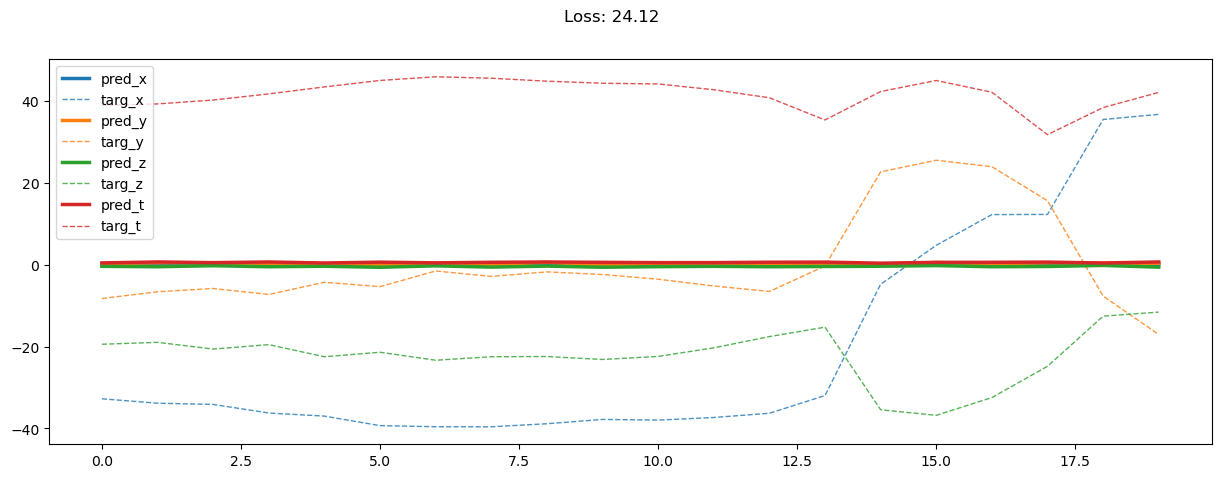

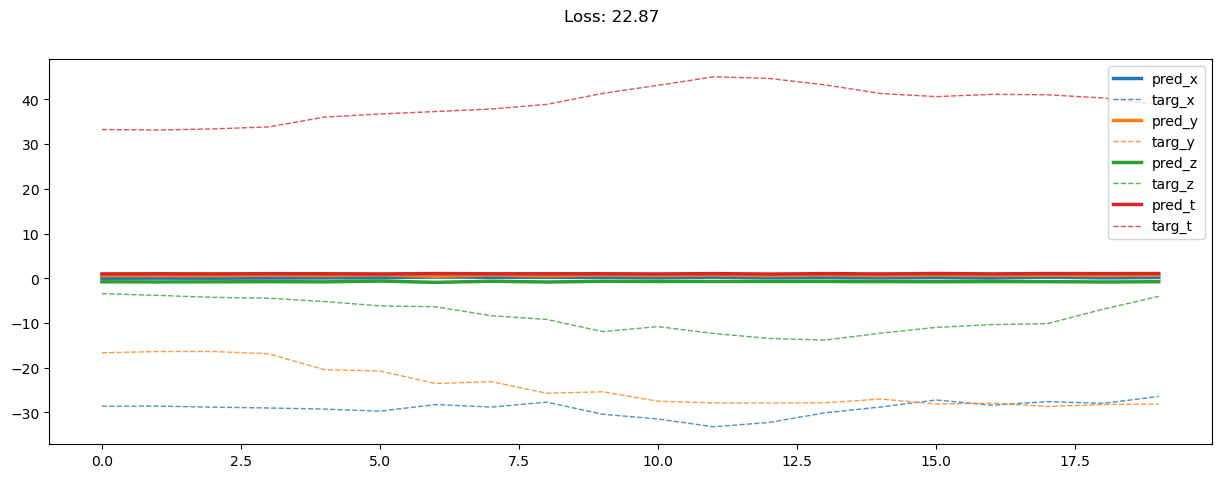

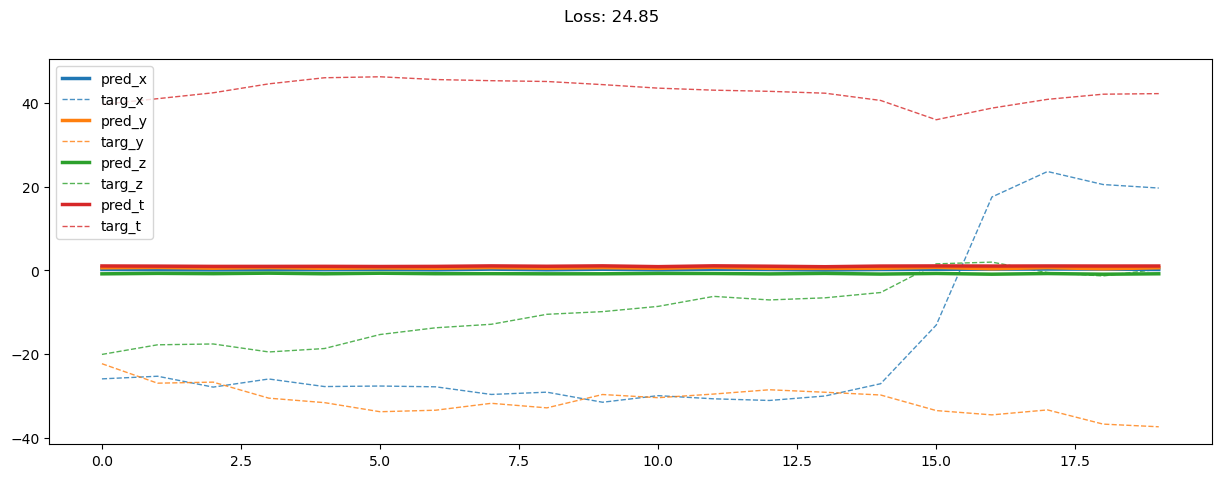

00000: train loss:  56.995, imu loss:  4.501, mag loss: 23.845, div loss: 18.658, slim: 40.315, tlim: 40.668
      train* loss:  88.319, imu loss:  4.588, mag loss: 23.777, div loss: 20.084, slim: 39.617, tlim: 39.954
      valid* loss:  66.503, imu loss:  3.271, mag loss: 21.848, div loss:  4.208, slim: 39.179, tlim: 36.508
00050: train loss:  53.419, imu loss:  4.449, mag loss: 23.445, div loss: 18.393, slim: 36.932, tlim: 37.350
      train* loss:  81.348, imu loss:  4.483, mag loss: 23.222, div loss: 16.900, slim: 36.481, tlim: 36.830
      valid* loss:  63.846, imu loss:  3.232, mag loss: 21.856, div loss:  4.186, slim: 36.576, tlim: 33.905
00100: train loss:  51.260, imu loss:  4.459, mag loss: 22.986, div loss: 16.779, slim: 35.947, tlim: 36.020
      train* loss:  81.379, imu loss:  4.685, mag loss: 22.929, div loss: 17.792, slim: 35.676, tlim: 36.072
      valid* loss:  62.196, imu loss:  3.235, mag loss: 21.581, div loss:  4.148, slim: 35.235, tlim: 32.564
00150: train loss: 

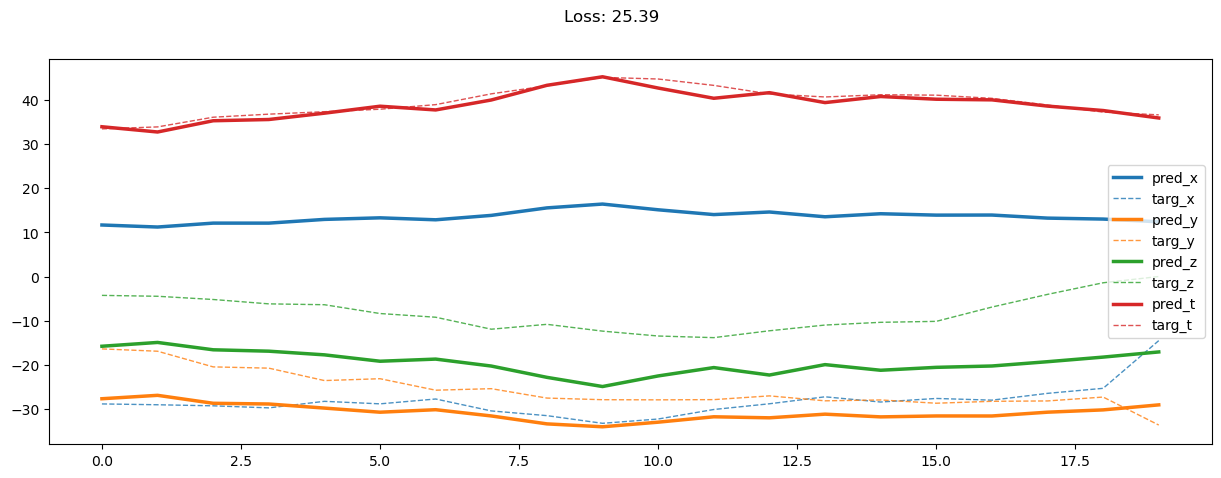

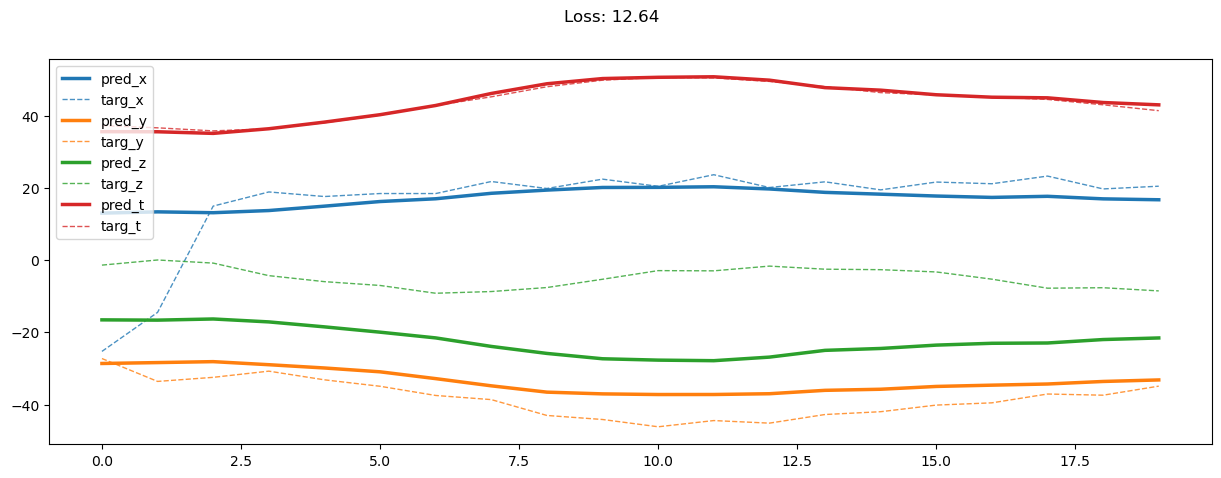

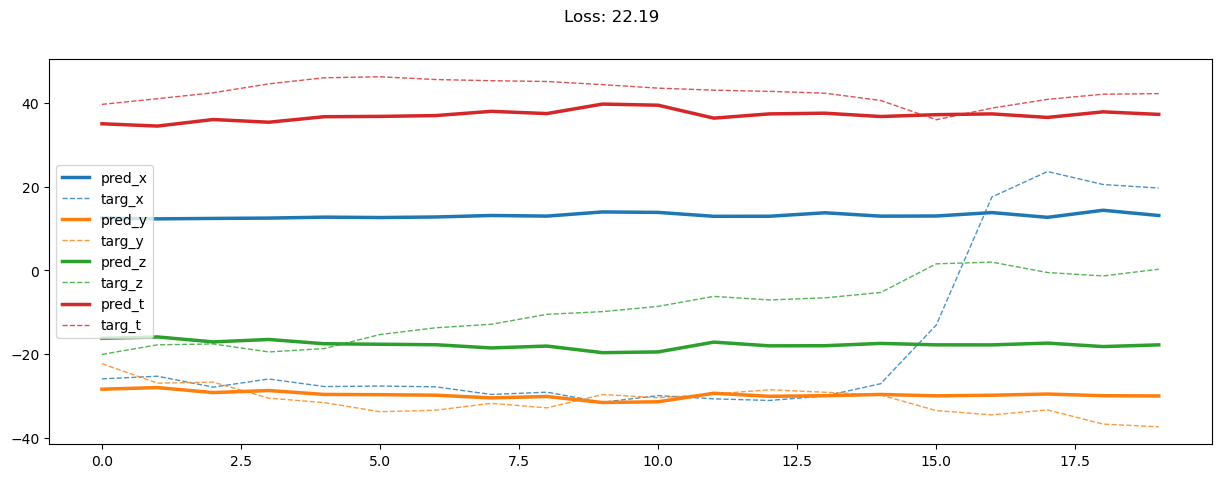

01000: train loss:  15.397, imu loss:  2.955, mag loss: 23.087, div loss: 15.140, slim:  2.664, tlim:  0.735
      train* loss:  40.999, imu loss:  2.479, mag loss: 22.791, div loss: 14.731, slim:  2.463, tlim:  0.509
      valid* loss:  41.384, imu loss:  4.116, mag loss: 25.927, div loss:  4.535, slim:  6.758, tlim:  6.823
01050: train loss:  15.312, imu loss:  2.847, mag loss: 23.285, div loss: 14.937, slim:  2.672, tlim:  0.710
      train* loss:  42.770, imu loss:  2.367, mag loss: 23.785, div loss: 15.627, slim:  2.485, tlim:  0.492
      valid* loss:  41.244, imu loss:  4.145, mag loss: 25.728, div loss:  4.515, slim:  6.763, tlim:  6.886
01100: train loss:  15.045, imu loss:  2.853, mag loss: 22.973, div loss: 14.602, slim:  2.526, tlim:  0.722
      train* loss:  39.311, imu loss:  2.429, mag loss: 21.533, div loss: 14.374, slim:  2.516, tlim:  0.462
      valid* loss:  40.369, imu loss:  4.128, mag loss: 25.087, div loss:  4.566, slim:  6.495, tlim:  6.620
01150: train loss: 

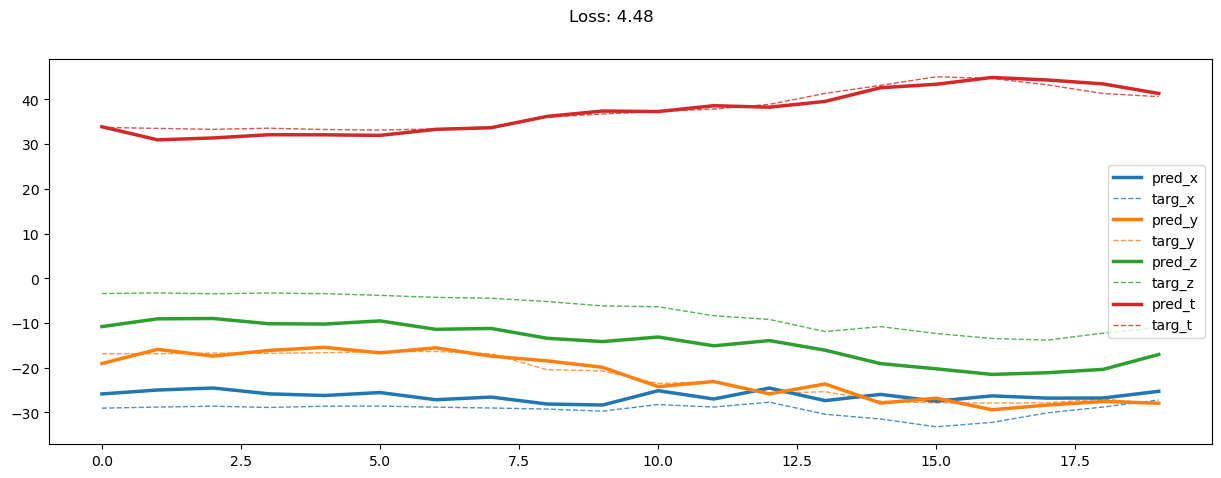

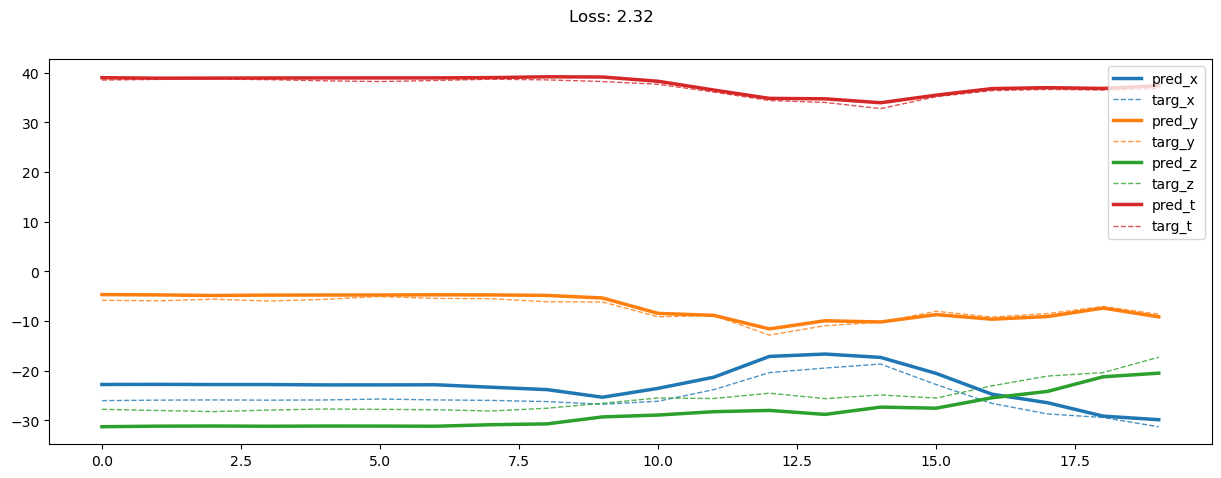

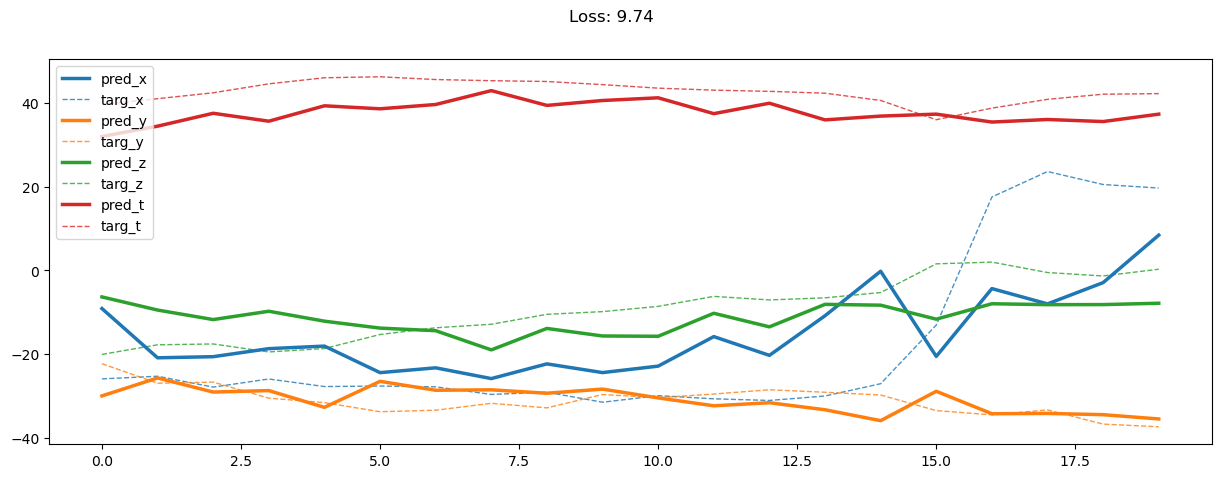

02000: train loss:   4.532, imu loss:  1.638, mag loss:  4.981, div loss:  3.289, slim:  2.486, tlim:  0.758
      train* loss:   9.642, imu loss:  1.188, mag loss:  4.638, div loss:  2.844, slim:  2.311, tlim:  0.526
      valid* loss:  32.535, imu loss:  4.494, mag loss: 13.576, div loss:  7.593, slim:  6.835, tlim:  6.885
02050: train loss:   4.132, imu loss:  1.566, mag loss:  4.237, div loss:  2.993, slim:  2.516, tlim:  0.699
      train* loss:   8.110, imu loss:  1.131, mag loss:  3.663, div loss:  2.275, slim:  2.626, tlim:  0.514
      valid* loss:  32.061, imu loss:  4.561, mag loss: 13.156, div loss:  7.402, slim:  6.897, tlim:  6.956
02100: train loss:   3.643, imu loss:  1.574, mag loss:  3.037, div loss:  2.598, slim:  2.619, tlim:  0.700
      train* loss:   7.057, imu loss:  1.165, mag loss:  2.891, div loss:  1.990, slim:  2.577, tlim:  0.489
      valid* loss:  31.751, imu loss:  4.509, mag loss: 13.131, div loss:  7.470, slim:  6.510, tlim:  6.685
02150: train loss: 

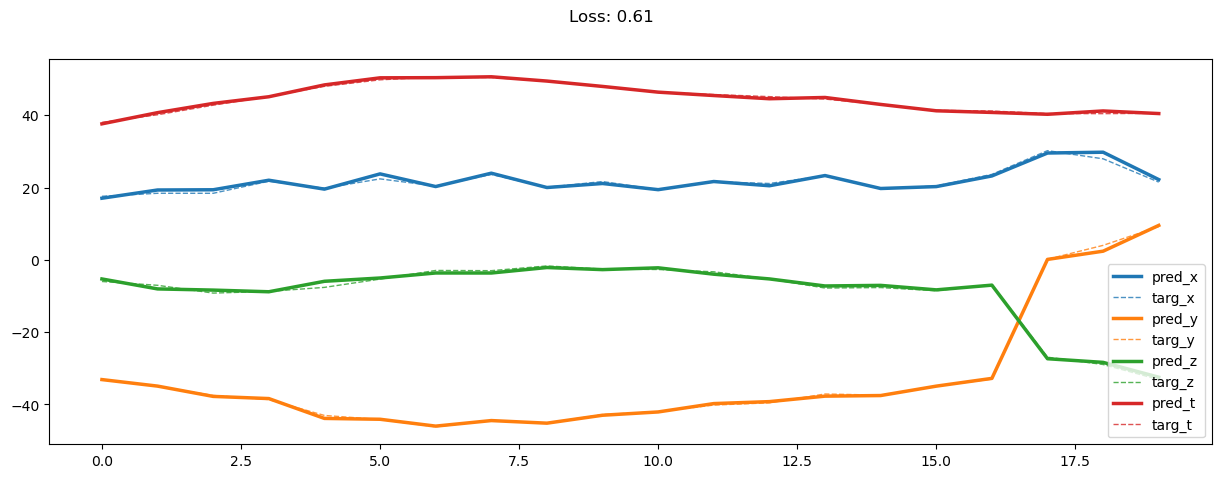

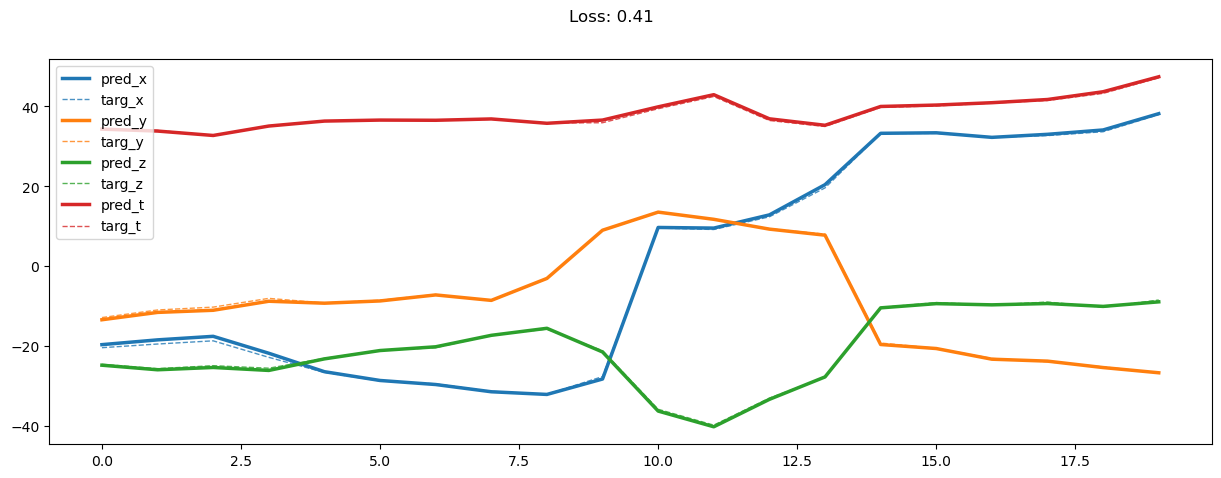

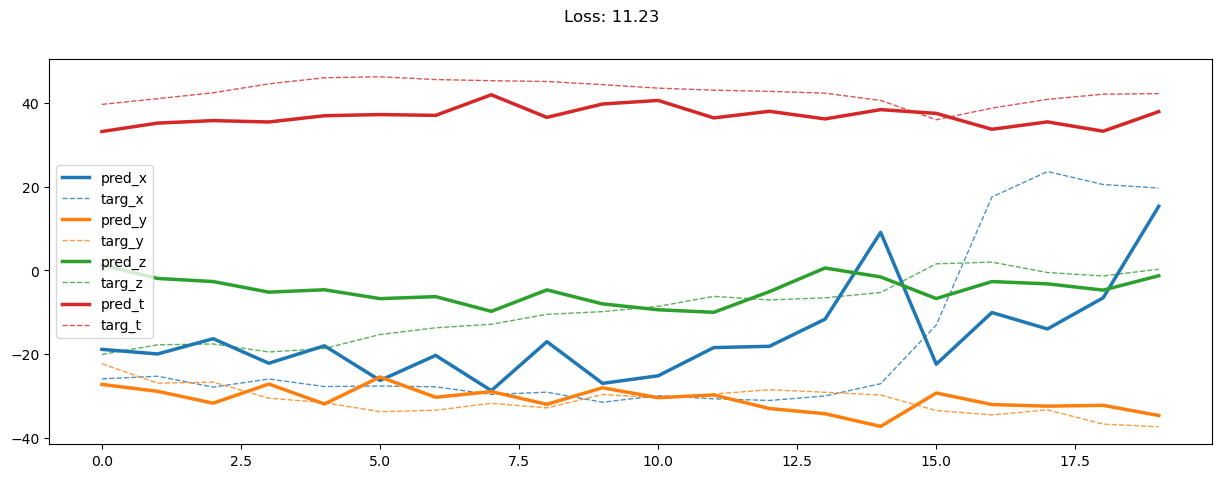

03000: train loss:   1.918, imu loss:  1.186, mag loss:  0.799, div loss:  0.855, slim:  2.761, tlim:  0.408
      train* loss:   2.811, imu loss:  0.934, mag loss:  0.481, div loss:  0.500, slim:  2.661, tlim:  0.308
      valid* loss:  33.452, imu loss:  4.616, mag loss: 14.147, div loss:  8.323, slim:  5.824, tlim:  6.548


KeyboardInterrupt: 

In [29]:
EPOCH = 20000
draw = False

for epoch in range(EPOCH+1):
    #####
    # 1. 用上半部訓練50epoch
    # 2. 隨機用上或下半部訓練Model
    # 3. 印出trajectory結果
    #####
    draw = ((epoch) % 1000 == 0)
    
    train_loss, train_imu_loss, train_mag_loss, t_d1_loss, tlim_loss = train(train_loader, draw, epoch / EPOCH)
    
    if epoch % 50 == 0:
        ttrain_loss, ttrain_imu_loss, ttrain_mag_loss, tt_d1_loss, ttlim_loss = evalute(train_loader, draw)
        valid_loss, valid_imu_loss, valid_mag_loss, v_d1_loss, vlim_loss = evalute(valid_loader, draw)
        print(f'{epoch:05d}: train loss: {train_loss:>7.3f}, imu loss: {train_imu_loss:>6.3f}, mag loss: {train_mag_loss:>6.3f}, div loss: {t_d1_loss:>6.3f}, slim: {tlim_loss[0]:>6.3f}, tlim: {tlim_loss[1]:>6.3f}\n' +
              f'{"":>5} train* loss: {ttrain_loss:>7.3f}, imu loss: {ttrain_imu_loss:>6.3f}, mag loss: {ttrain_mag_loss:>6.3f}, div loss: {tt_d1_loss:>6.3f}, slim: {ttlim_loss[0]:>6.3f}, tlim: {ttlim_loss[1]:>6.3f}\n' +
              f'{"":>5} valid* loss: {valid_loss:>7.3f}, imu loss: {valid_imu_loss:>6.3f}, mag loss: {valid_mag_loss:>6.3f}, div loss: {v_d1_loss:>6.3f}, slim: {vlim_loss[0]:>6.3f}, tlim: {vlim_loss[1]:>6.3f}')

(76, 4) (76, 3) (76,)
           loss name|   diff x   diff y   diff z      avg
          swing loss:     0.37     0.39     0.41     0.39
        average loss:     0.37     0.39     0.41     0.39


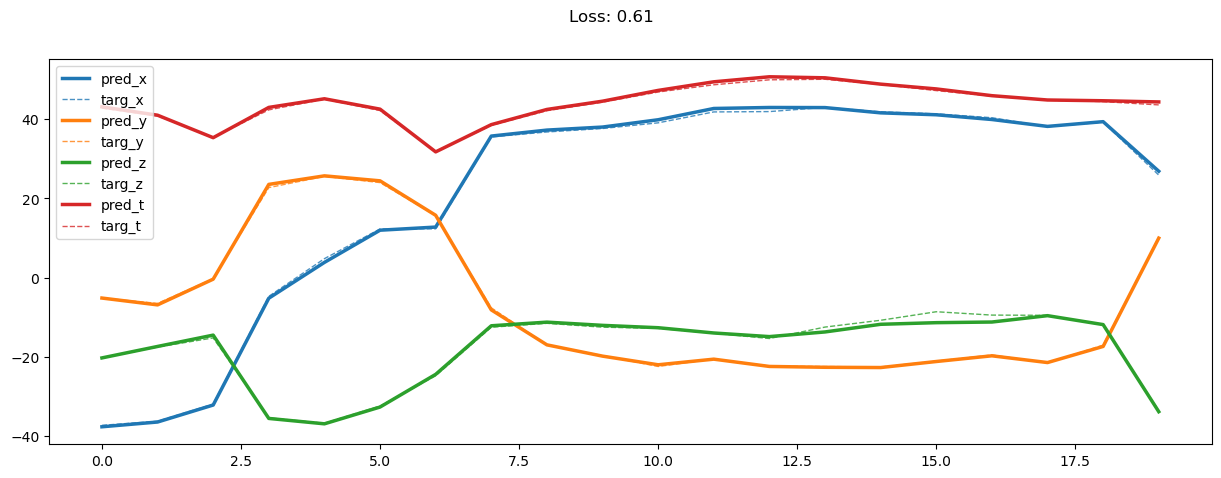

In [30]:
show_result(model, train_loader)

(24, 4) (24, 3) (24,)
           loss name|   diff x   diff y   diff z      avg
          swing loss:    17.93    12.22     9.26    13.14
        average loss:    17.93    12.22     9.26    13.14


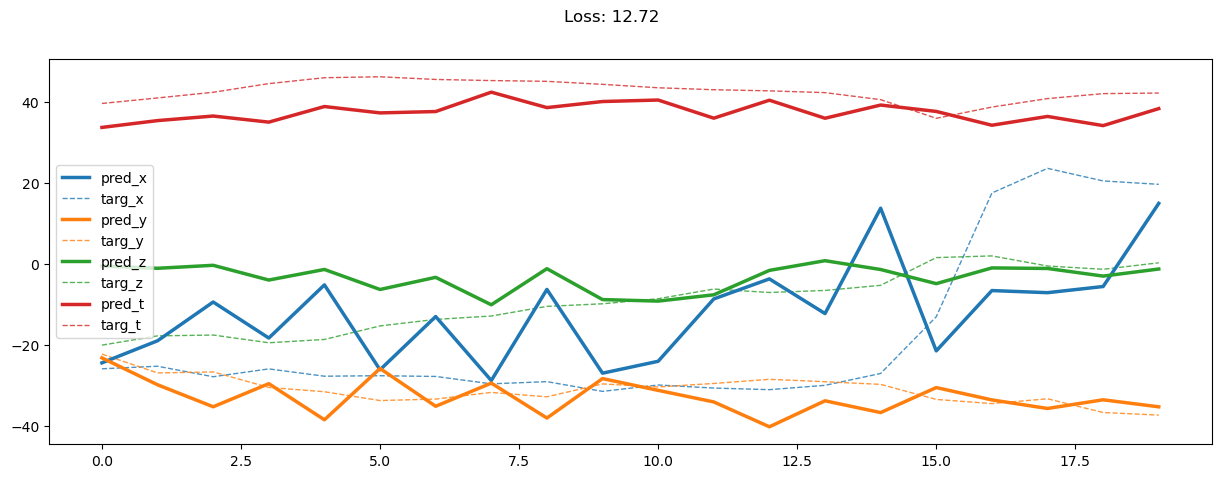

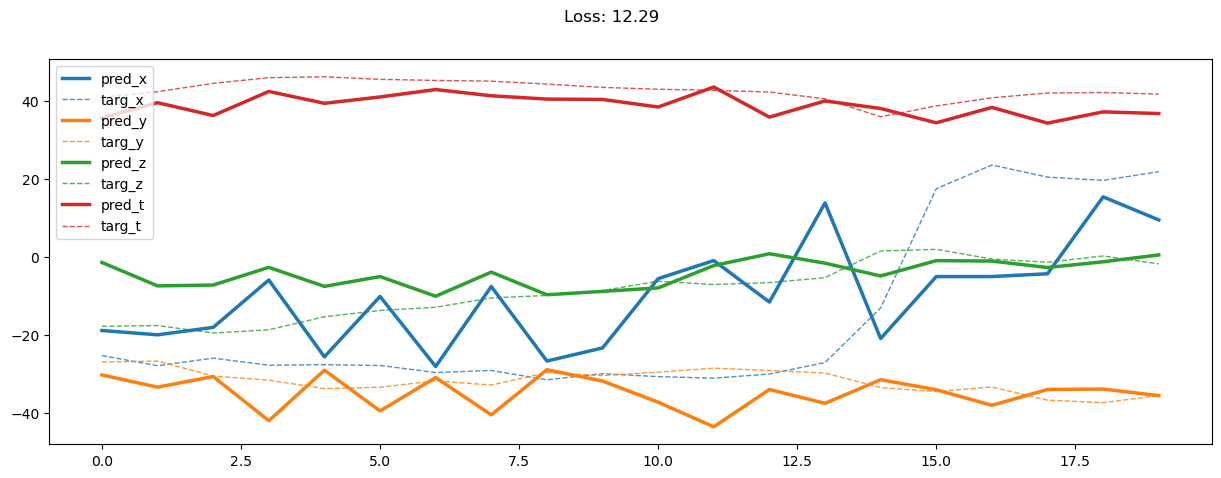

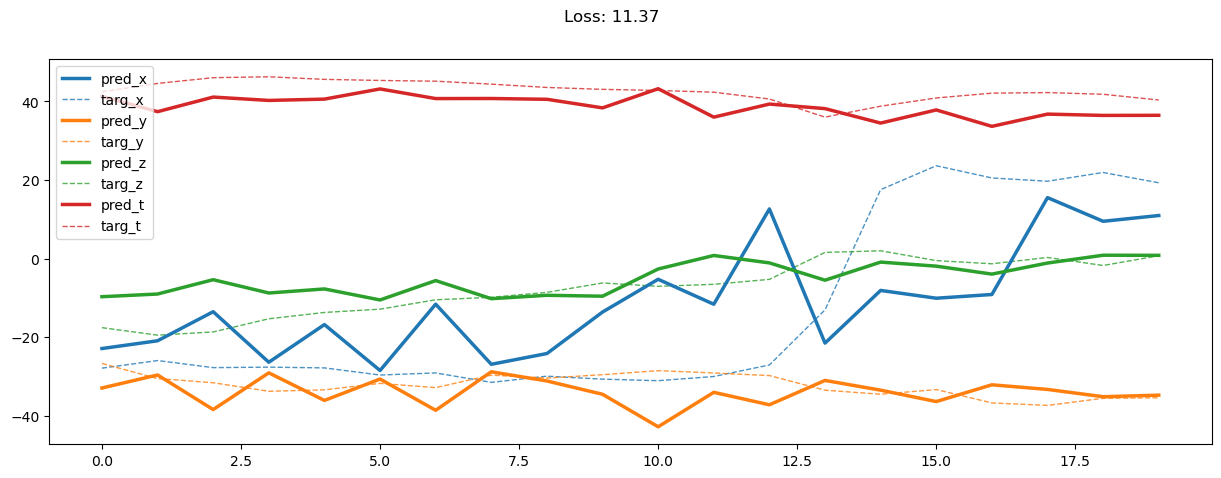

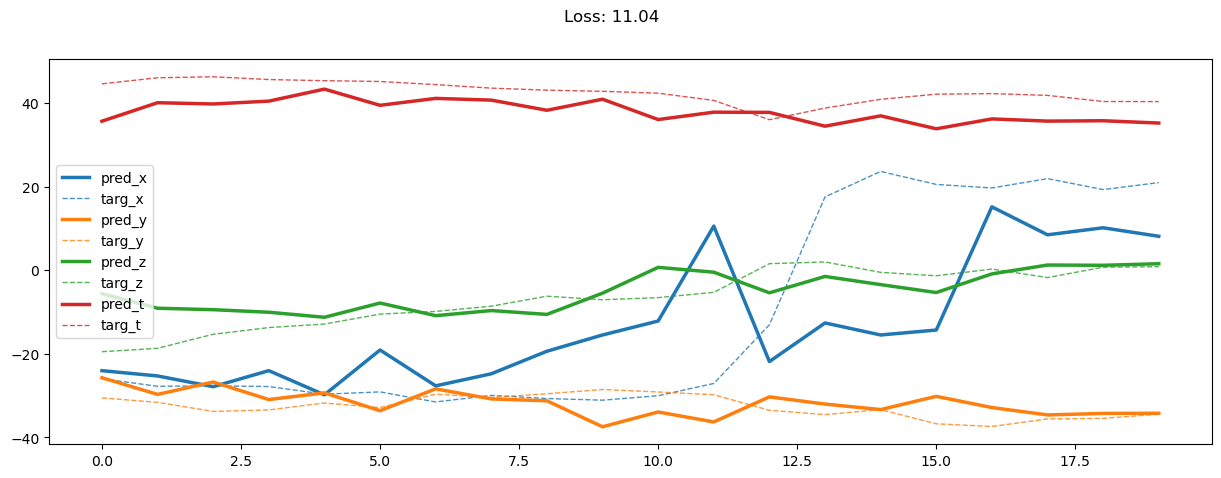

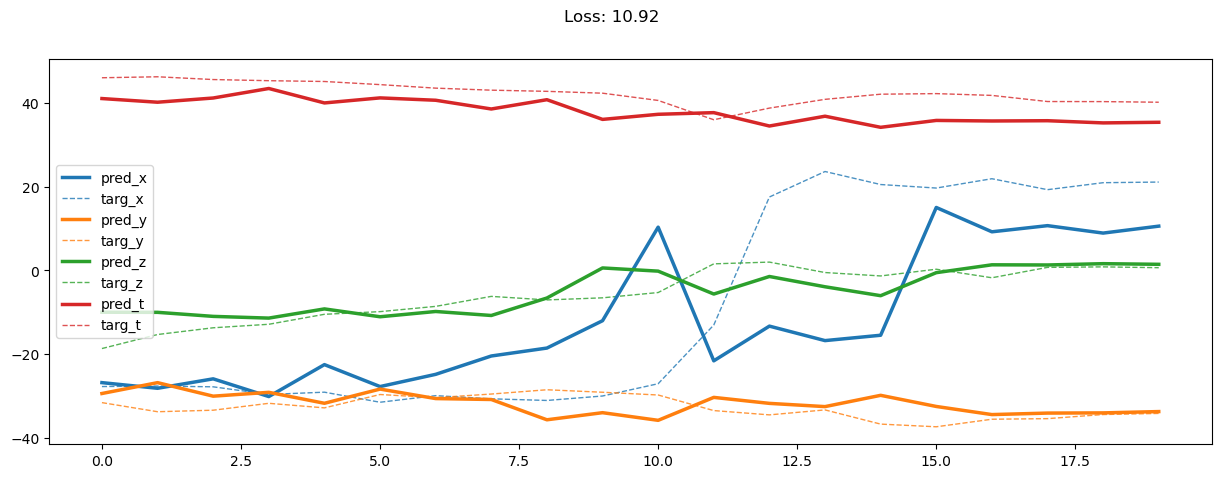

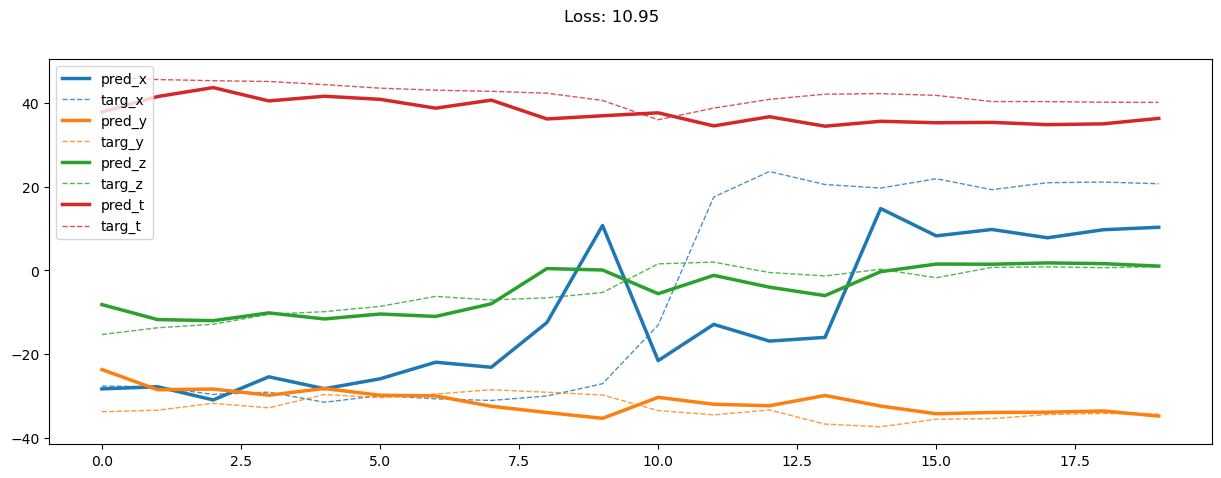

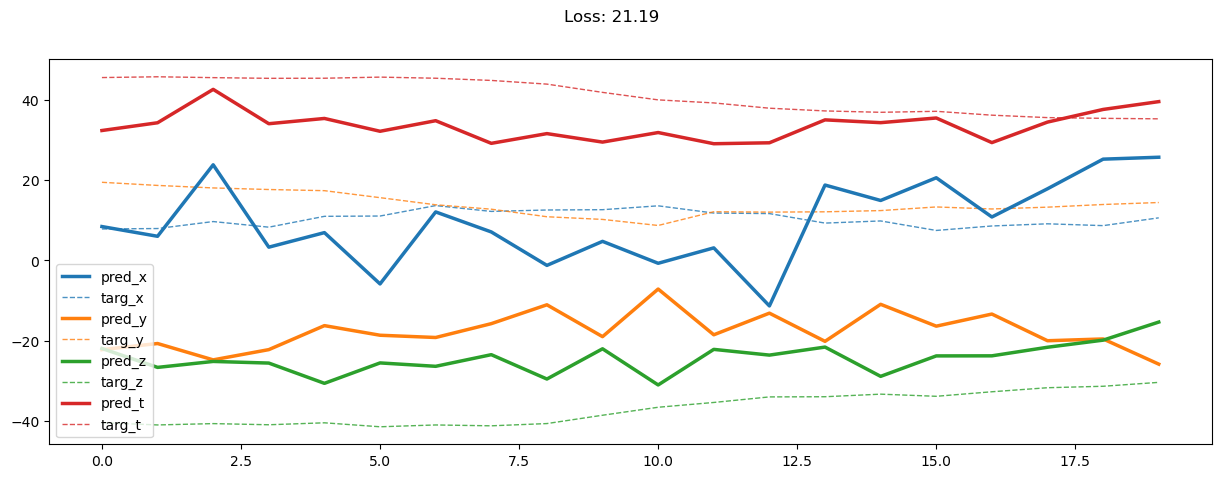

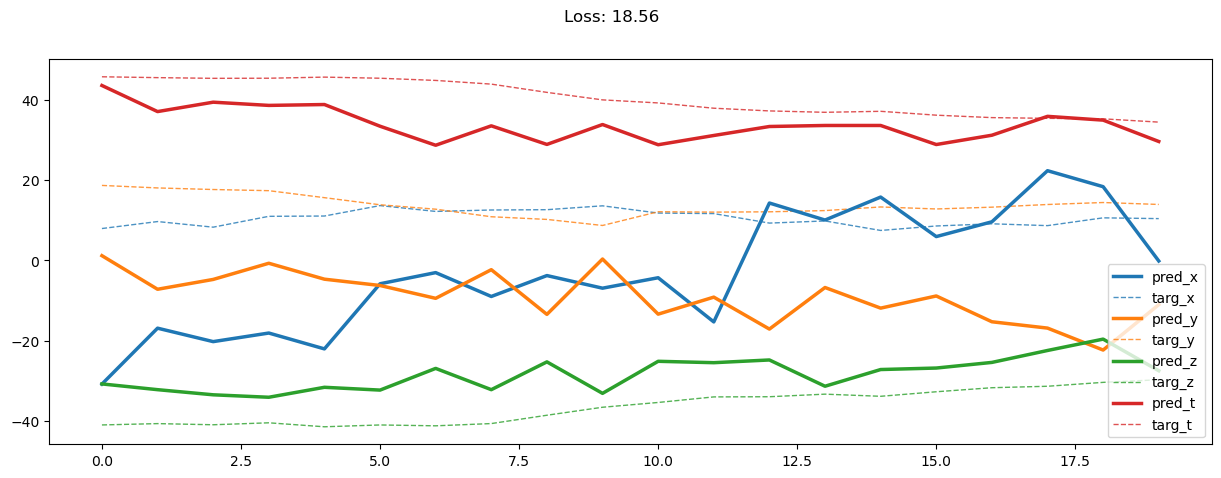

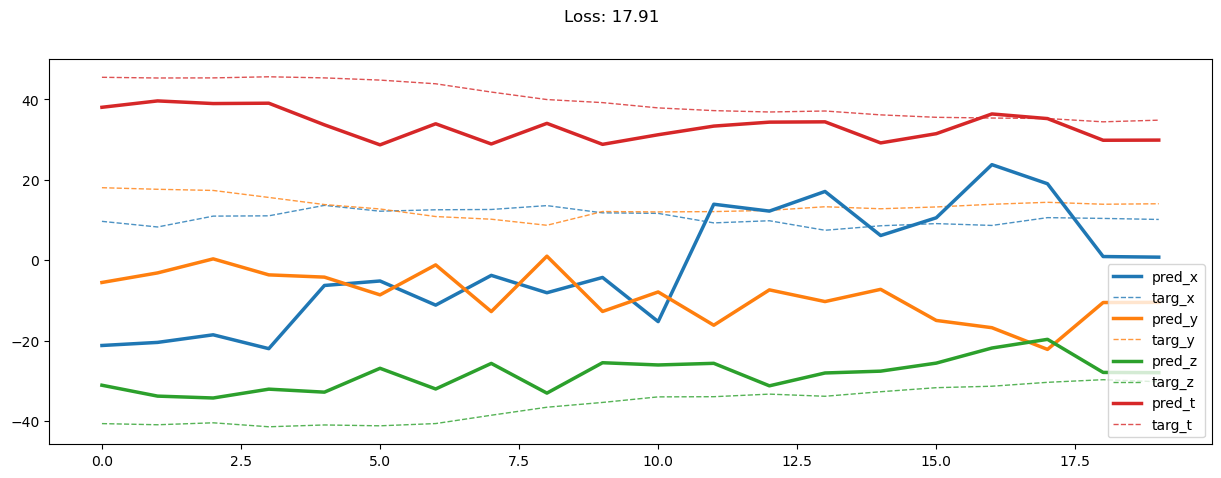

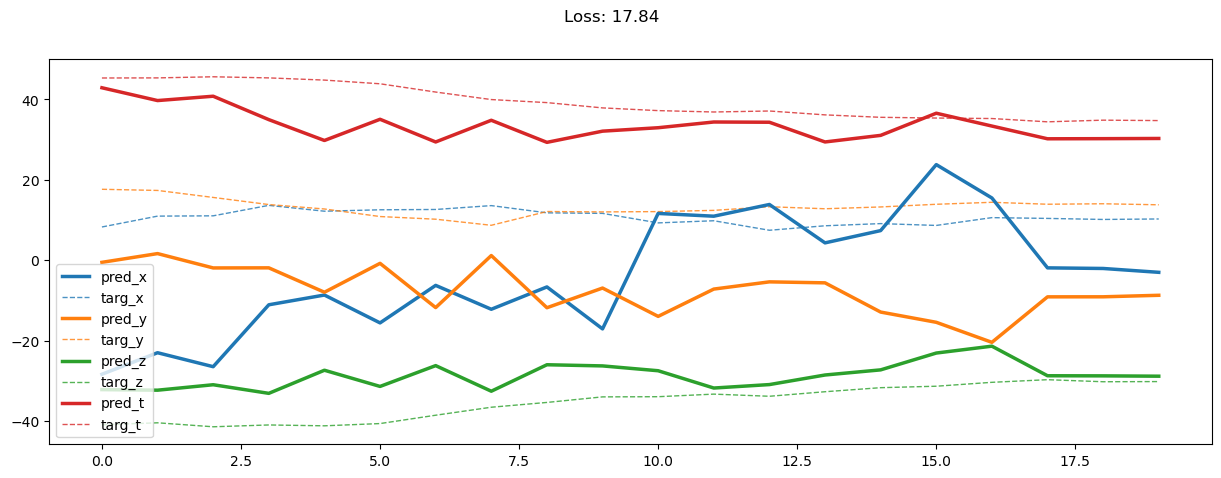

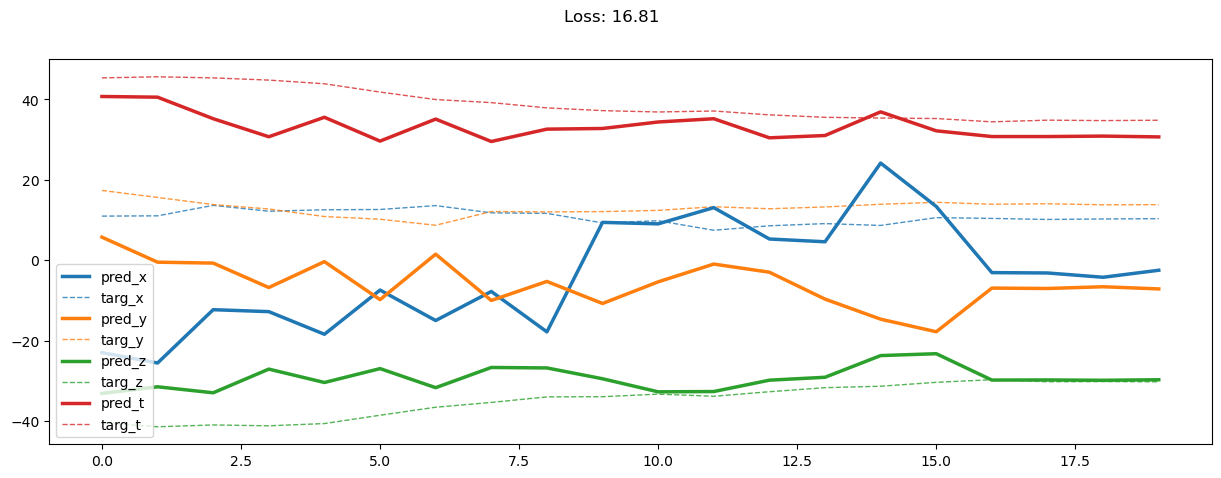

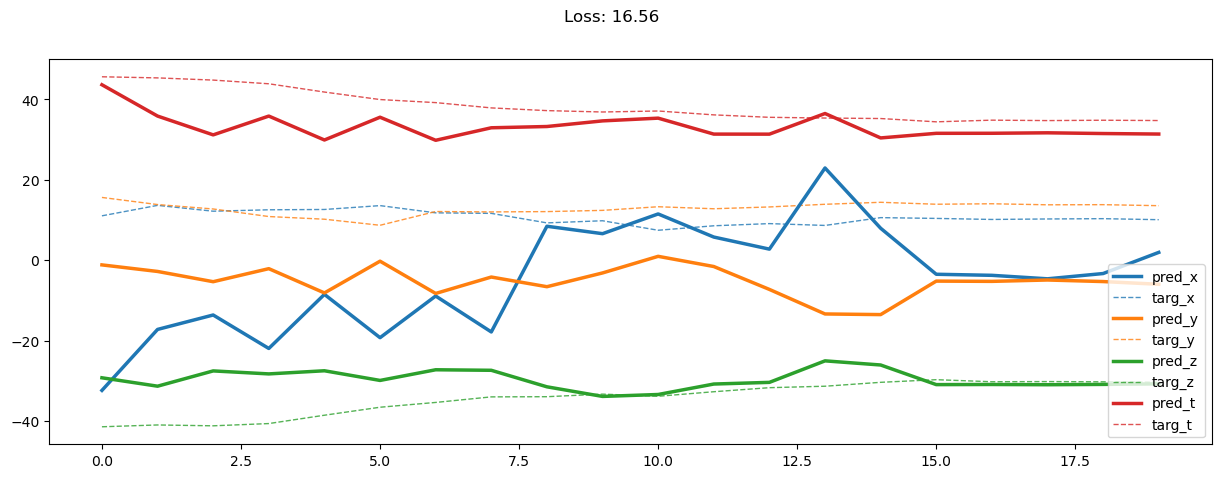

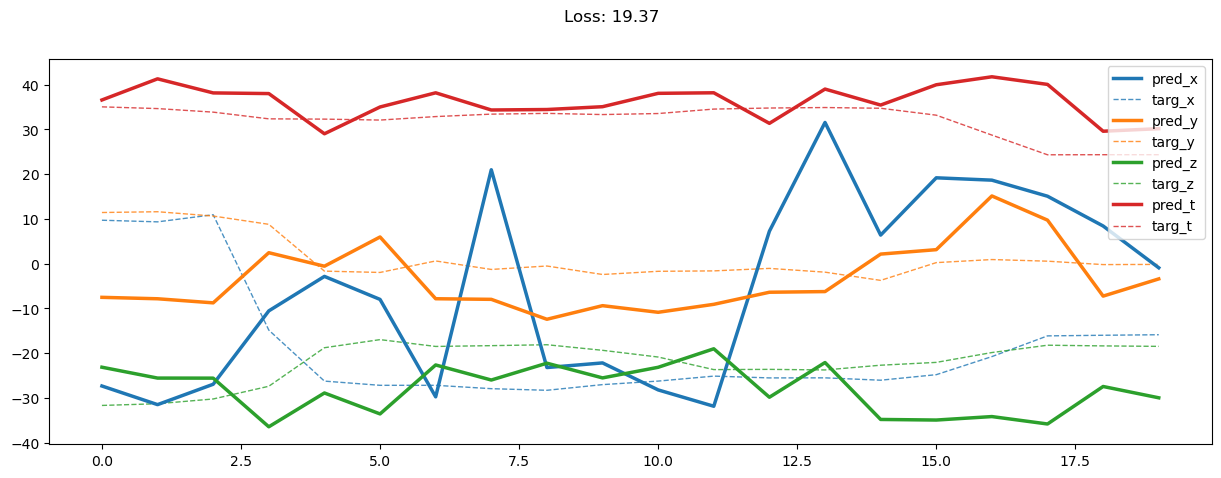

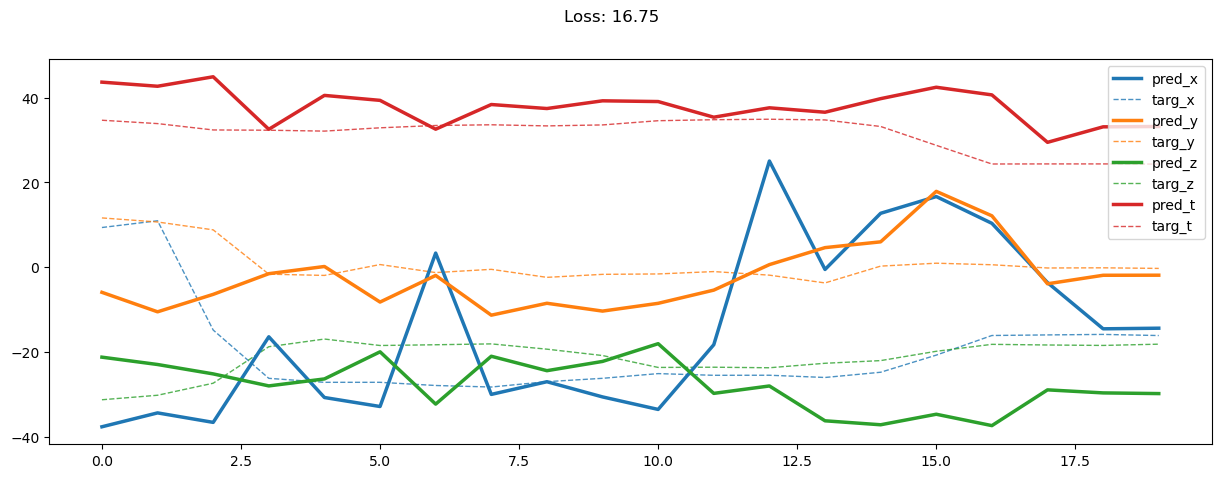

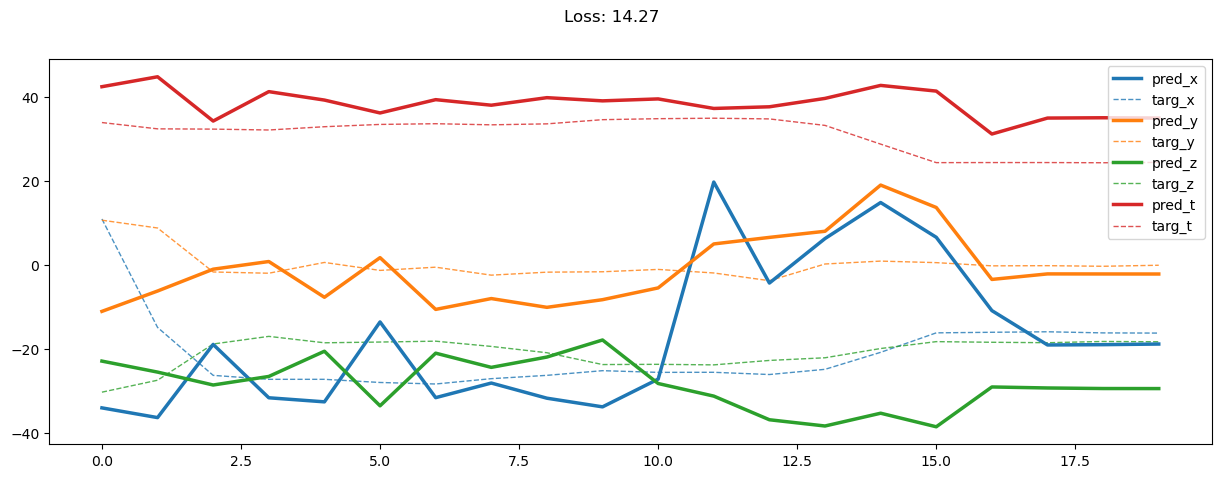

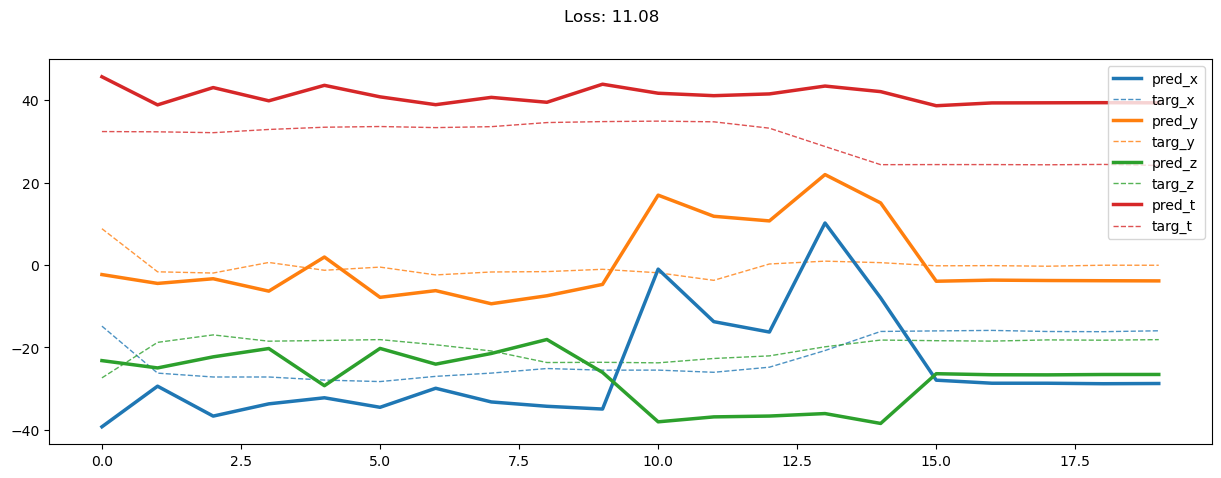

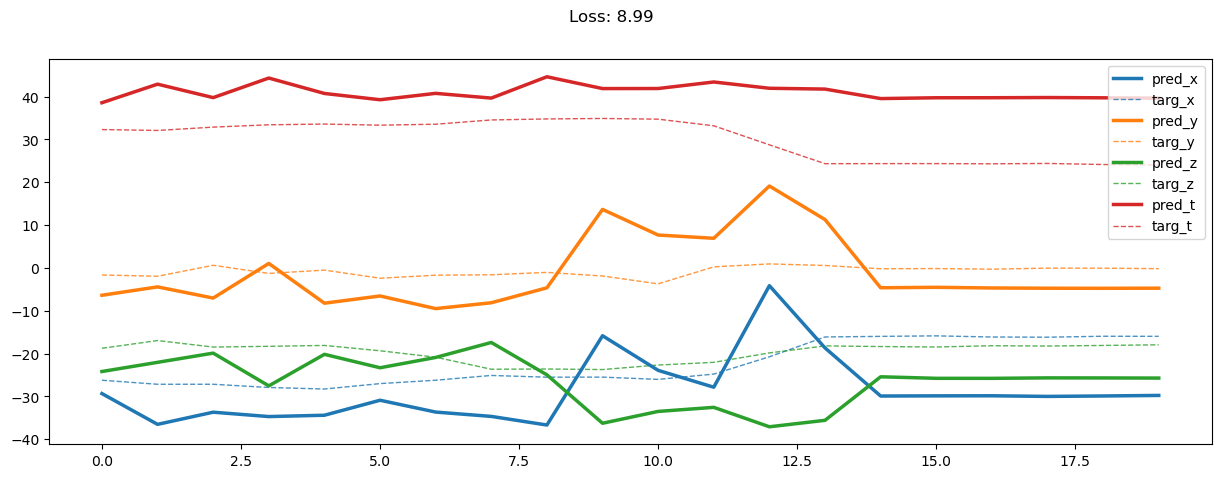

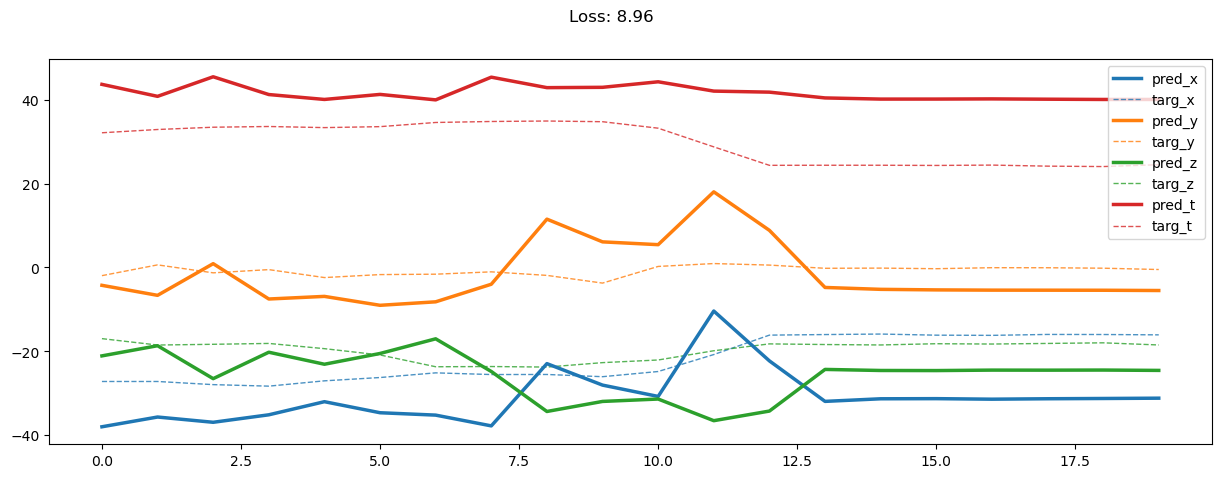

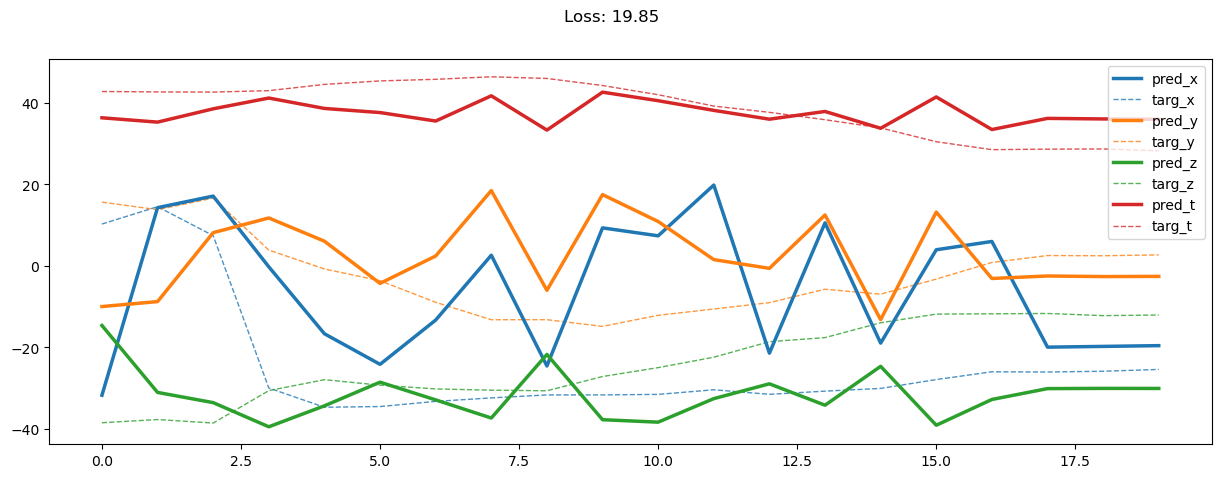

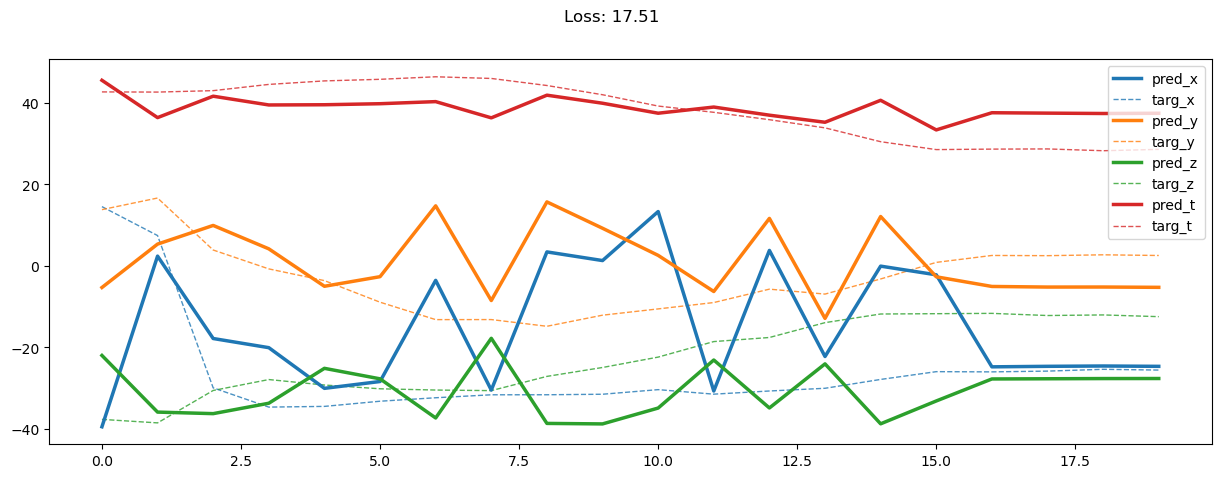

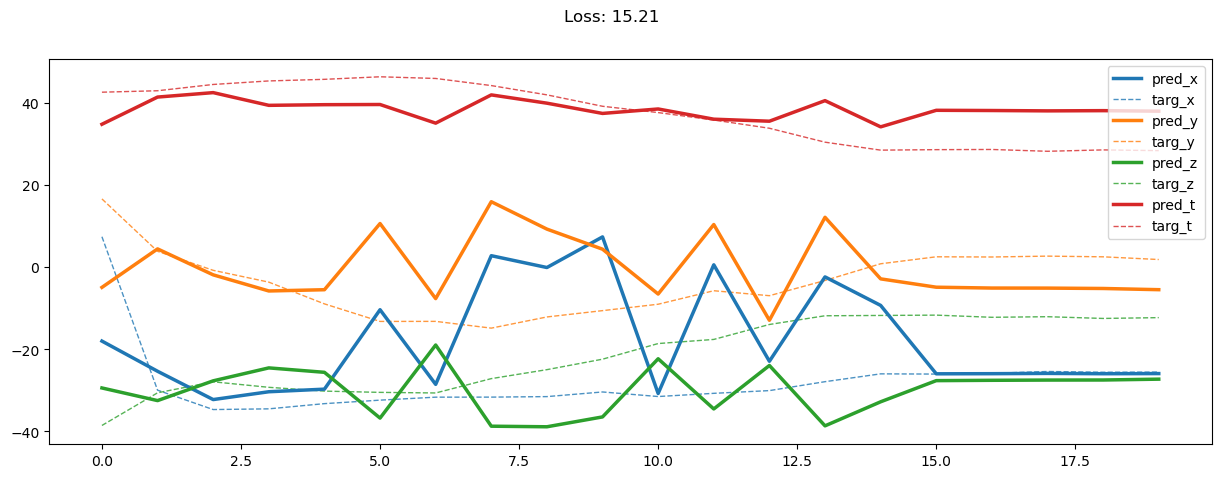

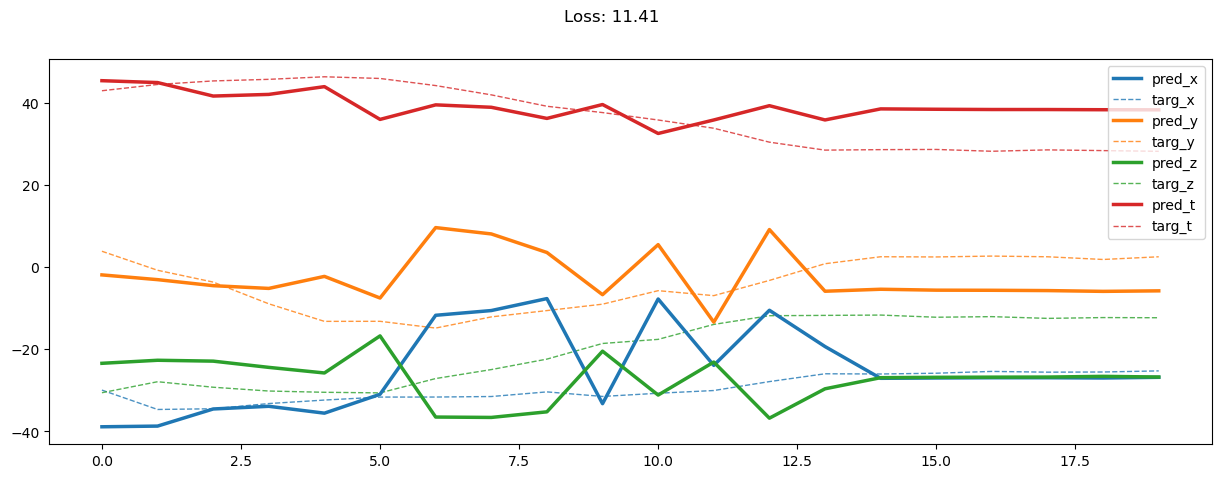

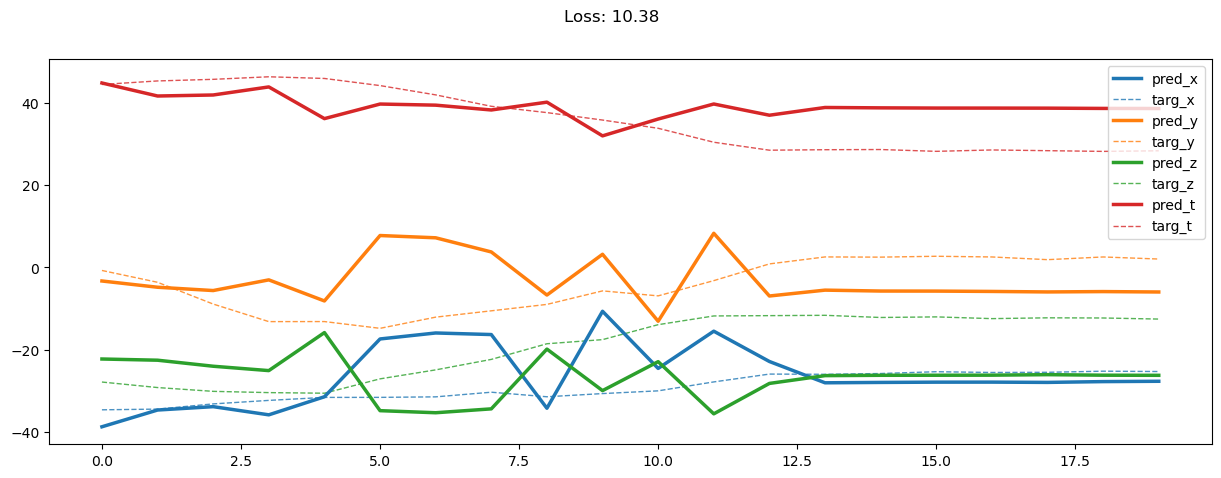

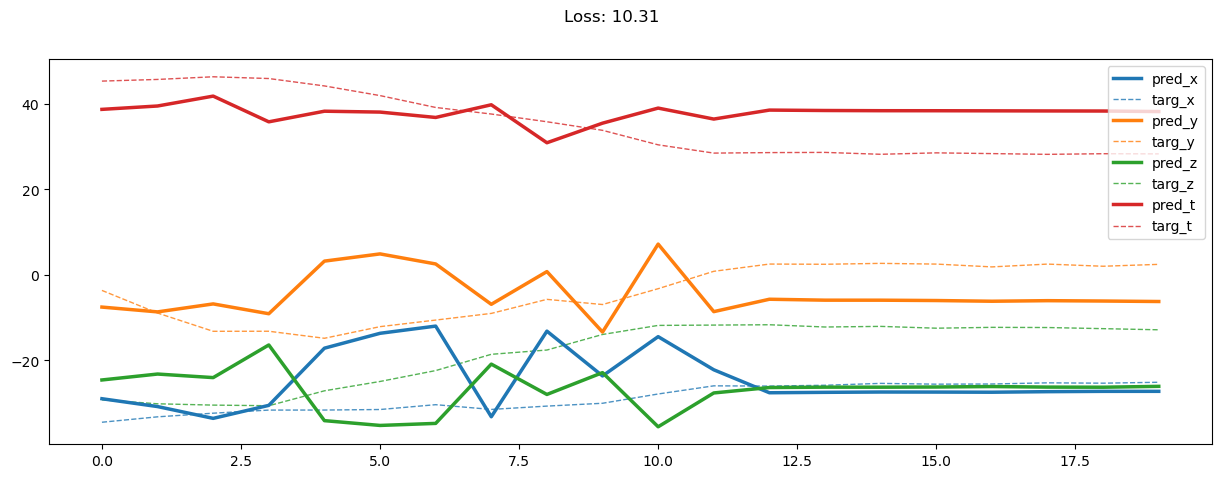

In [32]:
show_result(model, valid_loader, step=1)